In [2]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# install the Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
folium installed...
folium imported...
...Done


In [3]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [4]:
# Cleans html file
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
# This extracts the "tbody" within the table where class is "wikitable sortable"
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [5]:
# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')

In [6]:
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]

In [7]:
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [8]:
# Extracts every row with corresponding columns
# Then appends the values to the create pd dataframe "df"
# Please note that the first row (row[0]) is skipped because it is already the header
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [9]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[2],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [10]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [11]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[2],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Looking the data, under the Borough, there are borough names with []. These are references extracted from the wiki page. So remove these, the following was done:

In [12]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [13]:
df.shape

(533, 6)

In [14]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


London is big and due to the limitations in the number of calls for the Foursquare API, the following assumptions are made to confine this project to only South East London.

#### Assumption 1:
Where the Postcode are more than one, (for example, in Acton, there are 2 postcodes - W3 and W4), the postcodes are spread to multi-rows and assigned the same values from the other columns.

In [15]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [16]:
df0.head(5)

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [17]:
df0.shape

(638, 6)

#### Assumption 2: 
From the data, only the 'Location', 'Borough', 'Postcode', 'Post-town' will be used for this project. So they are extracted into a new data frame.

In [18]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [19]:
df1.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


#### Assumption 3: 
Now, only the Boroughs with London Post-town will be used for our search of location. Therefore, all the non-post-town are dropped.

In [20]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [21]:
df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [22]:
# Re-assigns the df21 to new dataframe without the Post-town
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [23]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [24]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

#### Assumption 4: 
Due to its more diverse outlook, proximity to asian markets and accessible facilities, only the South East areas of London will be considered for our analysis. The South East areas has postcodes starting with SE.
So, first, we remove the whitesapaces at the start of some of the postcodes and then drop the other non-SE postcodes.

In [25]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [26]:
df_london.Postcode = df_london.Postcode.str.strip()

In [27]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [29]:
# New dataframe for South East London postcodes - df_se
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [30]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


#### Assumption 5:
This assumption will focus on the demography of London where there are predominantly more multicultural groups. According to the proportion of races by London borough as seen in Demography of London, the top 5 demographs are as show:

In [31]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [32]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [35]:
demo_london = pd.DataFrame(columns = columns1)

In [36]:
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [37]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [38]:
demo_london['Asian'] = demo_london['Asian'].astype('float')

In [41]:
demo_london_sorted = demo_london.sort_values(by='Asian', ascending = False)

In [42]:
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
24,Newham,29,4.5,43.5,19.6,3.5
13,Harrow,42.2,4,42.6,8.2,2.9
25,Redbridge,42.5,4.1,41.8,8.9,2.7
29,Tower Hamlets,45.2,4.1,41.1,7.3,2.3
17,Hounslow,51.4,4.1,34.4,6.6,3.6


#### Assumption 6:
Our next assumption will be based on the 5 areas with  significantly high Mix.

In [47]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [48]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In obtaining the location data of the locations, the Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.
These will help to create a new dataframe that will be used subsequently for the South East London areas.

In [49]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

Applying it to our dataframe df_se_top.

In [51]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  24.16821312904358 seconds


Then we proceed to store the location data - latitude and longitude as follows. The obtained coordinates are then joined to df_se_topto create new data frame.

In [52]:
df_se_loc = df_se_top

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [53]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312
2,Deptford,Lewisham,SE8,51.48117,-0.02476
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [54]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)

In [55]:
df_se_loc.shape

(46, 5)

In [57]:
address = 'London'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [58]:
# create map of New York using latitude and longitude values
map_can = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, location in zip(df_se_loc['Latitude'], df_se_loc['Longitude'], df_se_loc['Borough'], df_se_loc['Location']):
    label = '{}, {}'.format(location, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_can)  
    
map_can

An initial exploration of a single Neighbourhood within the London area was done to examine the Foursquare workability. The Lewisham Borough postcode SE13 and Location - Lewisham is used for this.

In [59]:
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [60]:
se_df.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312
2,Deptford,Lewisham,SE8,51.48117,-0.02476
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [61]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


In [62]:
se_df.loc[20, 'Location']

'Lewisham'

In [64]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))


The latitude and longitude values of Lewisham with postcode SE13, are 51.46196000000003, -0.007539999999949032.


In [66]:
#Defining Foursquare credential and 
CLIENT_ID = 'HUZKQA4G4BDMP11PECKG4SS00TZLK1AXU2U3T1JBAEUQTULE' # your Foursquare ID
CLIENT_SECRET = '0O44S52G3KF0JRJUQ2YFV51P15JKNZDQJQ0HAJ30OZQFM1N5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HUZKQA4G4BDMP11PECKG4SS00TZLK1AXU2U3T1JBAEUQTULE
CLIENT_SECRET:0O44S52G3KF0JRJUQ2YFV51P15JKNZDQJQ0HAJ30OZQFM1N5


Let's explore the top 100 venues that are within a 2000 metres radius of Lewisham.
And then, let's create the GET request URL, and then the url is named.

In [67]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=HUZKQA4G4BDMP11PECKG4SS00TZLK1AXU2U3T1JBAEUQTULE&client_secret=0O44S52G3KF0JRJUQ2YFV51P15JKNZDQJQ0HAJ30OZQFM1N5&v=20180605&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

In [68]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ca8ac49db04f507fa11c046'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lewisham Central',
  'headerFullLocation': 'Lewisham Central, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 184,
  'suggestedBounds': {'ne': {'lat': 51.47996001800005,
    'lng': 0.021296961190459426},
   'sw': {'lat': 51.44395998200002, 'lng': -0.03637696119035749}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535823bc498ec8d8da9aad5f',
       'name': 'Street Feast Model Market',
       'location': {'address': '196 Lewisham High St',
        'crossStreet': 'entrance at Molesworth St',
        'lat': 51.46020945743763,
        'lng': -0.01

From the results, the necessary information needs to be obtained from items key. To do this, the get_category_type function is used from the Foursquare lab.

In [69]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [70]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [71]:
nearby_venues

,name,categories,lat,lng
0,Street Feast Model Market,Street Food Gathering,51.460209,-0.012199
1,Maggie's Kitchen,Café,51.465380,-0.011213
2,Gennaro Delicatessan,Deli / Bodega,51.461765,-0.009726
3,Levante Pide Restaurant,Turkish Restaurant,51.459848,-0.011476
4,Corte,Coffee Shop,51.459776,-0.011554
5,Levante restaurant,Restaurant,51.462072,-0.009491
6,Manor House Gardens,Park,51.456686,0.004684
7,Dirty South,Pub,51.458846,-0.002666
8,Blackheath Farmers' Market,Farmers Market,51.465913,0.007945
9,Buenos Aires Cafe,Argentinian Restaurant,51.467260,0.007083


In [74]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [75]:
nearby_venues_lewisham_unique.head(5)

,Count
Pub,13
Café,10
Gastropub,6
Park,6
Garden,4


Interestingly, even though there are restaurants are the Lewisham area, they are not even in the top 5 venues. It should be noted that since we are limited by data availability, our perspectives will be on what we have.

In [76]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Now let's explore (Multiple) Neighborhoods in the South East London area.
To do this, the function getNearbyVenues is used and it's created to repeat the same process for all neighborhoods.

In [77]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [79]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [80]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
1,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
2,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
3,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant
4,Crofton Park,51.46268,-0.03558,Masala Wala,51.465652,-0.036007,Pakistani Restaurant


In [81]:
se_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bankside,100,100,100,100,100,100
Bellingham,71,71,71,71,71,71
Bermondsey,100,100,100,100,100,100
Blackheath,92,92,92,92,92,92
Brixton,100,100,100,100,100,100
Brockley,100,100,100,100,100,100
Camberwell,100,100,100,100,100,100
Catford,71,71,71,71,71,71
Chinbrook,55,55,55,55,55,55


In [83]:
print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))

There are 188 uniques categories.


In [84]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')

In [85]:
se_venue_unique_count.head(5)

,Count
Pub,428
Coffee Shop,292
Café,289
Park,218
Grocery Store,167


In [86]:
se_venue_unique_count.describe()

,Count
count,188.000000
mean,22.601064
std,49.581191
min,1.000000
25%,4.000000
50%,8.000000
75%,17.250000
max,428.000000


For this section, the neighbourhoods in South East London will be clustered based on the processed data obtained above.

In [87]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [88]:
# df_london_coordinates
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

The South East London neighbourhoods are then superimposed on top as shown below, still using the foliumlibrary. Please note due to the location of the South East Loondon, you might need to zoom to see the superimposed areas.

In [89]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In this section, the objective is to check and explore the venues in each neighbourhood.

In [91]:
# one hot encoding
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [92]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [93]:
# move neighborhood column to the first column
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [94]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Winery,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [95]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Winery,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1897,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1898,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1899,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1900,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

As can be seen from above, Lewisham with its demography has no Asian restaurants within the top spots.

In [96]:
se_onehot.to_csv('selondon_onehot.csv', index = False)

In [97]:
se_onehot.shape

(4249, 189)

In [98]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Winery,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.00000,0.0,0.0,0.00000,0.01,0.03,0.0,0.01,0.0,0.0,0.0,0.010000,0.030000,0.00,0.00,0.01,0.01,0.0,0.0,0.00000,0.01,0.02,0.000000,0.010000,0.0,0.01,0.00,0.01,0.00000,0.0,0.000000,0.020000,0.080000,0.00,0.00000,0.01000,0.00,0.0,0.01,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.00000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.01,0.00,0.01,0.01,0.0,0.010000,0.0,0.000000,0.00,0.010000,0.0,0.000000,0.02000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.020000,0.000000,0.020000,0.0,0.0,0.000000,0.0,0.010000,0.01,0.0,0.06000,0.01,0.0,0.000000,0.01,0.000000,0.00,0.0,0.000000,0.050000,0.000000,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.01,0.00000,0.00,0.00000,0.0,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.00,0.010000,0.00000,0.000000,0.00000,0.00,0.00000,0.0,0.020000,0.070000,0.00,0.00,0.00000,0.030000,0.00000,0.000000,0.03,0.0,0.03,0.00000,0.01,0.000000,0.00000,0.0,0.0,0.01,0.000000,0.0,0.0,0.01,0.0,0.02,0.000000,0.0,0.0,0.02000,0.00000,0.040000,0.0,0.00000,0.0,0.010000,0.000000,0.0,0.000000,0.01,0.00,0.000000,0.01000,0.0,0.00,0.00,0.00000
1,Bellingham,0.00,0.00000,0.0,0.0,0.00000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.014085,0.014085,0.00,0.00,0.00,0.00,0.0,0.0,0.00000,0.00,0.00,0.028169,0.042254,0.0,0.00,0.00,0

In [99]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (46, 5)
After One-hot encoding: (40, 189)


In [100]:
se_grouped.to_csv('london_grouped.csv', index = False)

Grouping of each Neighbourhoods with 10 common venues:

In [101]:
num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                venue  freq
0         Coffee Shop  0.08
1                 Pub  0.07
2               Hotel  0.06
3  Italian Restaurant  0.05
4             Theater  0.04
5      Scenic Lookout  0.03
6                 Bar  0.03
7  Seafood Restaurant  0.03
8          Art Museum  0.03
9          Restaurant  0.03


----Bellingham----
                  venue  freq
0         Grocery Store  0.17
1                  Park  0.10
2           Supermarket  0.08
3                   Pub  0.06
4  Fast Food Restaurant  0.04
5                  Café  0.04
6           Gas Station  0.03
7              Bus Stop  0.03
8         Train Station  0.03
9    Italian Restaurant  0.03


----Bermondsey----
                venue  freq
0         Coffee Shop  0.08
1                 Pub  0.07
2               Hotel  0.06
3  Italian Restaurant  0.05
4             Theater  0.04
5      Scenic Lookout  0.03
6                 Bar  0.03
7  Seafood Restaurant  0.03
8          Art Museum  0.03
9          Restaurant  

Creating new dataframe: 
Putting the common venues into pandas dataframe, the following return_most_common_venuesis used to sort the venues in descending order.

In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [103]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [104]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Coffee Shop,Pub,Hotel,Italian Restaurant,Theater,Seafood Restaurant,Restaurant,Bar,Scenic Lookout,Art Museum
1,Bellingham,Grocery Store,Park,Supermarket,Pub,Café,Fast Food Restaurant,Italian Restaurant,Coffee Shop,Train Station,Bus Stop
2,Bermondsey,Coffee Shop,Pub,Hotel,Italian Restaurant,Theater,Seafood Restaurant,Restaurant,Bar,Scenic Lookout,Art Museum
3,Blackheath,Pub,Coffee Shop,Grocery Store,Park,Café,Bakery,Garden,Train Station,Italian Restaurant,Indian Restaurant
4,Brixton,Café,Coffee Shop,Park,Italian Restaurant,Pub,Cocktail Bar,Pizza Place,Bar,Grocery Store,Beer Bar


In [105]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [106]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

The next thing to do now, is to create clusters of the neighbourhood using the k-means to cluster the neighbourhood into 5 clusters.

In [107]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 1, 4, 0, 2, 0, 2, 1, 3, 0], dtype=int32)

In [109]:
kmeans.labels_[0:10]

array([4, 1, 4, 0, 2, 0, 2, 1, 3, 0], dtype=int32)

Now creating a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

In [110]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [111]:
se_merged = se_df

In [112]:
se_merged.head(3)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312
2,Deptford,Lewisham,SE8,51.48117,-0.02476


In [113]:
# match/merge SE London data with latitude/longitude for each neighborhood
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')


In [114]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,0,Pub,Coffee Shop,Café,Park,Bar,Pizza Place,Gastropub,Bakery,Italian Restaurant,Fish & Chips Shop
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312,2,Café,Coffee Shop,Park,Italian Restaurant,Pub,Cocktail Bar,Pizza Place,Bar,Grocery Store,Beer Bar
2,Deptford,Lewisham,SE8,51.48117,-0.02476,0,Pub,Coffee Shop,Café,Bar,Park,Vietnamese Restaurant,History Museum,Indie Movie Theater,Italian Restaurant,Historic Site
3,Dulwich,Southwark,SE21,51.44100,-0.08897,0,Pub,Café,Grocery Store,Park,Bakery,Coffee Shop,Italian Restaurant,Train Station,Pizza Place,Gym / Fitness Center
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,2,Café,Pub,Coffee Shop,Pizza Place,Park,Gastropub,Burger Joint,Italian Restaurant,Cocktail Bar,Bakery


In [115]:
se_clusters = se_merged_latlong

Get the Optimal Number of Clusters for K-mean 

In [116]:
%matplotlib inline
import matplotlib
import numpy as np

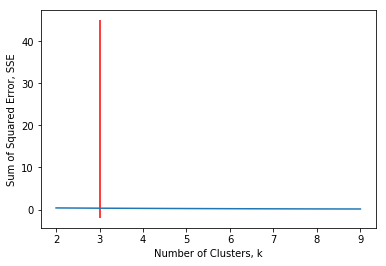

In [117]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

In [119]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6987346521113167
Where n_clusters = 3, the Silhouette Coefficient is 0.6405930891583029
Where n_clusters = 4, the Silhouette Coefficient is 0.6515393340367122
Where n_clusters = 5, the Silhouette Coefficient is 0.6542439873872079
Where n_clusters = 6, the Silhouette Coefficient is 0.7287963344111693
Where n_clusters = 7, the Silhouette Coefficient is 0.8041482964195896
Where n_clusters = 8, the Silhouette Coefficient is 0.8869699587229078
Where n_clusters = 9, the Silhouette Coefficient is 0.9373102923079768


From the result, the high the n_clusters the better the silhouette coefficient. For this project, a cluster value of 5 will be used.

In [120]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [121]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [122]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,0,Pub,Coffee Shop,Café,Park,Bar,Pizza Place,Gastropub,Bakery,Italian Restaurant,Fish & Chips Shop
2,Lewisham,0,Pub,Coffee Shop,Café,Bar,Park,Vietnamese Restaurant,History Museum,Indie Movie Theater,Italian Restaurant,Historic Site
3,Southwark,0,Pub,Café,Grocery Store,Park,Bakery,Coffee Shop,Italian Restaurant,Train Station,Pizza Place,Gym / Fitness Center
9,Lewisham,0,Pub,Coffee Shop,Grocery Store,Café,Park,Supermarket,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Italian Restaurant
10,Lambeth,0,Pub,Coffee Shop,Grocery Store,Park,Café,Italian Restaurant,Bakery,Train Station,Pizza Place,Gym / Fitness Center
11,Lambeth,0,Pub,Coffee Shop,Grocery Store,Park,Café,Italian Restaurant,Bakery,Train Station,Pizza Place,Gym / Fitness Center
14,Lewisham,0,Pub,Café,Gastropub,Park,Coffee Shop,Garden,Restaurant,Fish & Chips Shop,Supermarket,Food Truck
15,Lewisham,0,Pub,Coffee Shop,Grocery Store,Café,Park,Supermarket,Gym / Fitness Center,Pizza Place,Japanese Restaurant,Italian Restaurant
16,Lewisham,0,Pub,Café,Coffee Shop,Park,Gastropub,Fish & Chips Shop,Bar,Bakery,Food Truck,Italian Restaurant
17,Lewisham,0,Pub,Café,Coffee Shop,Park,Gastropub,Fish & Chips Shop,Bar,Bakery,Food Truck,Italian Restaurant


In [123]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Lewisham,1,Grocery Store,Park,Supermarket,Pub,Café,Fast Food Restaurant,Italian Restaurant,Coffee Shop,Train Station,Bus Stop
29,Croydon,1,Grocery Store,Pub,Supermarket,Park,Coffee Shop,Café,Platform,Clothing Store,Hotel,Plaza
31,Croydon,1,Grocery Store,Pub,Supermarket,Park,Coffee Shop,Café,Platform,Clothing Store,Hotel,Plaza
32,Lewisham,1,Grocery Store,Park,Supermarket,Pub,Café,Fast Food Restaurant,Italian Restaurant,Coffee Shop,Train Station,Bus Stop
44,Lewisham,1,Grocery Store,Park,Supermarket,Pub,Café,Fast Food Restaurant,Italian Restaurant,Coffee Shop,Train Station,Bus Stop


In [124]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Southwark,2,Café,Coffee Shop,Park,Italian Restaurant,Pub,Cocktail Bar,Pizza Place,Bar,Grocery Store,Beer Bar
4,Southwark,2,Café,Pub,Coffee Shop,Pizza Place,Park,Gastropub,Burger Joint,Italian Restaurant,Cocktail Bar,Bakery
13,Lambeth,2,Café,Pub,Coffee Shop,Pizza Place,Market,Brewery,Park,Bakery,Cocktail Bar,Caribbean Restaurant
24,Southwark,2,Pub,Café,Pizza Place,Coffee Shop,Park,Bar,Gastropub,Burger Joint,Cocktail Bar,Indie Movie Theater
27,Southwark,2,Pub,Café,Pizza Place,Coffee Shop,Park,Bar,Gastropub,Burger Joint,Cocktail Bar,Indie Movie Theater
35,Lambeth,2,Pub,Coffee Shop,Café,Grocery Store,Park,Pizza Place,Bakery,Brewery,Gym / Fitness Center,Italian Restaurant
36,Lambeth,2,Pub,Coffee Shop,Café,Grocery Store,Park,Pizza Place,Bakery,Brewery,Gym / Fitness Center,Italian Restaurant
41,Lambeth,2,Café,Coffee Shop,Park,Italian Restaurant,Pub,Cocktail Bar,Pizza Place,Bar,Grocery Store,Beer Bar
43,Southwark,2,Café,Coffee Shop,Park,Italian Restaurant,Pub,Cocktail Bar,Pizza Place,Bar,Grocery Store,Beer Bar


In [125]:
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Lewisham,3,Grocery Store,Pub,Café,Park,Coffee Shop,Gym / Fitness Center,Train Station,Italian Restaurant,Supermarket,Flower Shop
19,Lewisham,3,Grocery Store,Pub,Café,Park,Coffee Shop,Gym / Fitness Center,Train Station,Italian Restaurant,Supermarket,Flower Shop
40,Lambeth,3,Pub,Grocery Store,Coffee Shop,Café,Park,Bakery,Italian Restaurant,Train Station,Pizza Place,Gym / Fitness Center
45,Lewisham,3,Grocery Store,Pub,Café,Park,Coffee Shop,Gym / Fitness Center,Train Station,Italian Restaurant,Supermarket,Flower Shop


In [126]:
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,4,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Bar,Gastropub,Gym / Fitness Center
6,Southwark,4,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Bar,Gastropub,Gym / Fitness Center
7,Southwark,4,Pub,Café,Coffee Shop,Hotel,Italian Restaurant,Theater,Park,Bar,Gastropub,Gym / Fitness Center
8,Southwark,4,Coffee Shop,Pub,Hotel,Italian Restaurant,Theater,Seafood Restaurant,Restaurant,Bar,Scenic Lookout,Art Museum
18,Lambeth,4,Coffee Shop,Pub,Hotel,Italian Restaurant,Theater,Seafood Restaurant,Restaurant,Bar,Scenic Lookout,Art Museum
22,Southwark,4,Coffee Shop,Pub,Italian Restaurant,Café,Hotel,Theater,Bar,Gastropub,Tapas Restaurant,Park
23,Southwark,4,Coffee Shop,Pub,Italian Restaurant,Café,Hotel,Theater,Bar,Gastropub,Tapas Restaurant,Park
25,Lambeth,4,Café,Pub,Hotel,Park,Bar,Theater,Art Gallery,Gym / Fitness Center,Plaza,Beer Bar
30,Southwark,4,Coffee Shop,Pub,Hotel,Italian Restaurant,Theater,Seafood Restaurant,Restaurant,Bar,Scenic Lookout,Art Museum
38,Southwark,4,Coffee Shop,Pub,Café,Italian Restaurant,Park,Theater,Art Gallery,Cocktail Bar,French Restaurant,Brewery


### Result 
The following are the highlights of the 5 clusters above:

1. Pubs, Cafe, Coffee Shops are popular in the South East London.
2. As for restaurants, the Italian Restaurants are very popular in the South East London area. Especially in Southwark and Lambeth areas.
3. With the Lewisham area being the most condensed area of Africans in the South East Area, it is surprising to see how in the top 10 venues, you can barely see restaurants in the top 5 venues.
4. Although, the Clusters have variations, a very visible presence is the predominance of pubs.

### Discussion and Conclusion 
It is very important to note that Clusters 2 and 3 are the most viable clusters to create a brand African Restaurant. Their proximity to other amenities and accessibility to station are paramount. These 2 clusters do not have top restaurants that could rival their standards if they are created. And the proximity to resources needed is paramount as Lewisham and Lambeth are not far out from Peckham (under Southwark).
In conclusion, this project would have had better results if there were more data in terms of crime data within the area, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls).
Also, getting the ratings and feedbacks of the current restaurants within the clusters would have helped in providing more insight into the best location.


